Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:

from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
root_path = r"/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration"
data_dir_train = pathlib.Path(os.path.join(root_path, "Train"))
data_dir_test = pathlib.Path(os.path.join(root_path, "Test"))


In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    subset="training",
    validation_split = 0.2
    )

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    subset="validation",
    validation_split = 0.2
    )

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

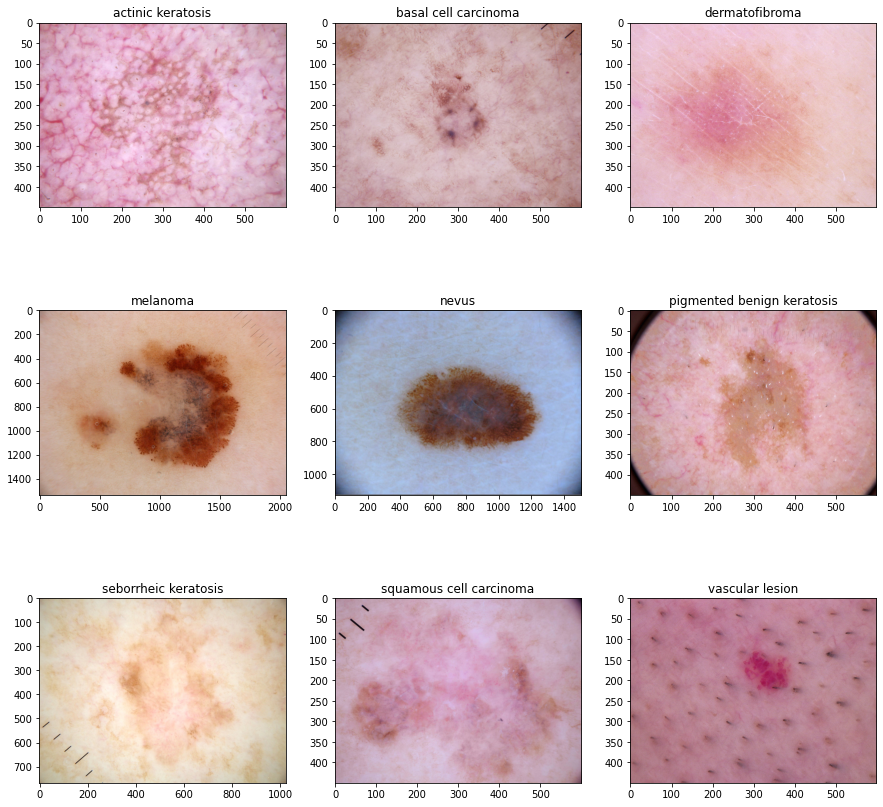

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
# function to plot n images using subplots
fig = plt.figure(figsize=(15,15))
num_class_names =  len(class_names)
for class_name in range(0,num_class_names):
    image_path = os.path.join(data_dir_train, class_names[class_name])
    image_name = os.listdir(image_path)[10]
    image = plt.imread(os.path.join(image_path, image_name))
    ax = fig.add_subplot(3, 3, class_name+1)
    ax.set_title(class_names[class_name])  
    plt.imshow(image)
plt.show()


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
### Your code goes here

# Sequential model creation
model = Sequential()

# Rescaling the pixel values between (0,1)
model.add(layers.Rescaling(scale = 1./255, input_shape = (180,180,3)))

# First convolution layer
model.add(layers.Conv2D(16,3,padding='same',activation= 'relu'))


# Second convolution layer
model.add(layers.Conv2D(32,3,padding='same',activation= 'relu'))


# Third convolution layer
model.add(layers.Conv2D(64,3,padding='same',activation= 'relu'))


# Flattern and Dense Layer
model.add(layers.Flatten())
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dense(num_class_names, activation= 'softmax'))


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 64)      18496     
                                                                 
 flatten (Flatten)           (None, 2073600)           0         
                                                                 
 dense (Dense)               (None, 128)               265420928 
                                                                 
 dense_1 (Dense)             (None, 9)                 1

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [13]:
### Todo, choose an appropirate optimiser and loss function
# optimiser - adam
# loss function -  SparseCategoricalCrossentropy
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 64)      18496     
                                                                 
 flatten (Flatten)           (None, 2073600)           0         
                                                                 
 dense (Dense)               (None, 128)               265420928 
                                                                 
 dense_1 (Dense)             (None, 9)                 1

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 1678s 3s/step - loss: 3.6990 - accuracy: 0.3286 - val_loss: 1.4858 - val_accuracy: 0.4380
Epoch 2/20
169/169 [==============================] - 24s 143ms/step - loss: 1.4094 - accuracy: 0.4866 - val_loss: 1.3396 - val_accuracy: 0.5256
Epoch 3/20
169/169 [==============================] - 24s 142ms/step - loss: 1.0572 - accuracy: 0.6274 - val_loss: 1.0324 - val_accuracy: 0.6310
Epoch 4/20
169/169 [==============================] - 24s 143ms/step - loss: 0.7277 - accuracy: 0.7611 - val_loss: 0.9924 - val_accuracy: 0.6771
Epoch 5/20
169/169 [==============================] - 24s 142ms/step - loss: 0.5246 - accuracy: 0.8357 - val_loss: 1.0075 - val_accuracy: 0.7068
Epoch 6/20
169/169 [==============================] - 24s 142ms/step - loss: 0.3705 - accuracy: 0.8832 - val_loss: 0.9312 - val_accuracy: 0.7060
Epoch 7/20
169/169 [==============================] - 24s 142ms/step - loss: 0.2597 - accuracy: 0.9214 - val_loss: 0.9848 - val_acc

### Visualizing training results

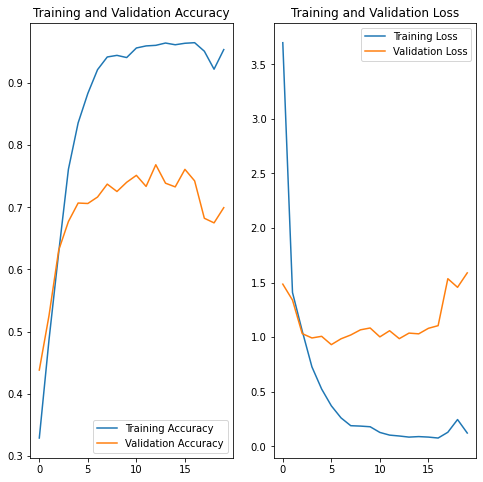

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

# Finding

1. Accurancy for training is above 95% and for validation is around 69%.
2. Loss for training is decreaing but for validation is increaing.

From the above two pooints , we can  say model is overfitting.

### Write your findings here

In [17]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

for img, label in train_ds.take(1):
    images = img
    augumented_images = data_augmentation(img)
  

32
32


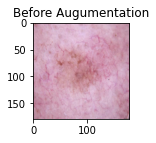

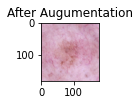

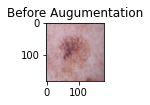

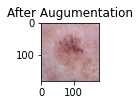

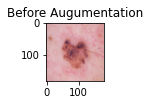

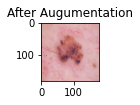

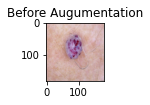

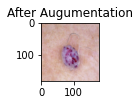

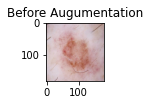

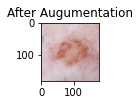

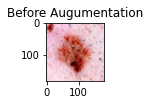

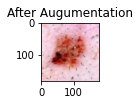

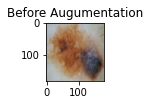

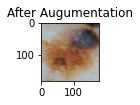

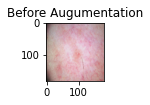

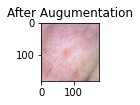

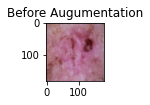

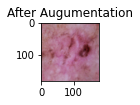

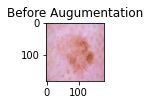

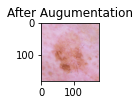

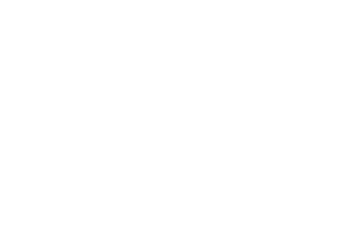

In [19]:
print(len(images))
print(len(augumented_images))
plt.figure(figsize=(10, 10))
for i in range(10):
        ax = plt.subplot(2, 5, 1 + i)
        ax.imshow(images[i].numpy().astype("uint8"))
        ax.set_title('Before Augumentation')
        plt.show()

        ay = plt.subplot(2, 5, 1 + i)
        ay.imshow(augumented_images[i].numpy().astype("uint8"))
        ay.set_title('After Augumentation')
        plt.show()

        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [20]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
# Sequential model creation
model_1 = Sequential()

# Rescaling the pixel values between (0,1)
model_1.add(layers.Rescaling(scale = 1./255, input_shape = (180,180,3)))

# adding data augumentation layer
model_1.add(data_augmentation)

# First convolution layer
model_1.add(layers.Conv2D(16,3,padding='same',activation= 'relu'))
model_1.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_1.add(layers.Dropout(0.25))

# Second convolution layer
model_1.add(layers.Conv2D(32,3,padding='same',activation= 'relu'))
model_1.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_1.add(layers.Dropout(0.25))

# Third convolution layer
model_1.add(layers.Conv2D(64,3,padding='same',activation= 'relu'))
model_1.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_1.add(layers.Dropout(0.25))

# Flattern and Dense Layer
model_1.add(layers.Flatten())
model_1.add(layers.Dense(128,activation='relu'))
model_1.add(layers.Dense(num_class_names, activation= 'softmax'))




### Compiling the model

In [21]:
model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [22]:
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                      

### Training the model

In [23]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history_1 = model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 10s 49ms/step - loss: 2.3759 - accuracy: 0.1473 - val_loss: 2.1574 - val_accuracy: 0.1477
Epoch 2/20
169/169 [==============================] - 8s 48ms/step - loss: 1.8362 - accuracy: 0.2886 - val_loss: 1.7051 - val_accuracy: 0.3578
Epoch 3/20
169/169 [==============================] - 8s 48ms/step - loss: 1.6135 - accuracy: 0.3874 - val_loss: 1.4832 - val_accuracy: 0.4581
Epoch 4/20
169/169 [==============================] - 9s 52ms/step - loss: 1.5137 - accuracy: 0.4217 - val_loss: 1.4624 - val_accuracy: 0.4722
Epoch 5/20
169/169 [==============================] - 10s 61ms/step - loss: 1.4274 - accuracy: 0.4555 - val_loss: 1.3897 - val_accuracy: 0.4670
Epoch 6/20
169/169 [==============================] - 10s 57ms/step - loss: 1.4149 - accuracy: 0.4557 - val_loss: 1.3746 - val_accuracy: 0.4573
Epoch 7/20
169/169 [==============================] - 9s 52ms/step - loss: 1.3587 - accuracy: 0.4820 - val_loss: 1.3369 - val_accuracy: 0.4

### Visualizing the results

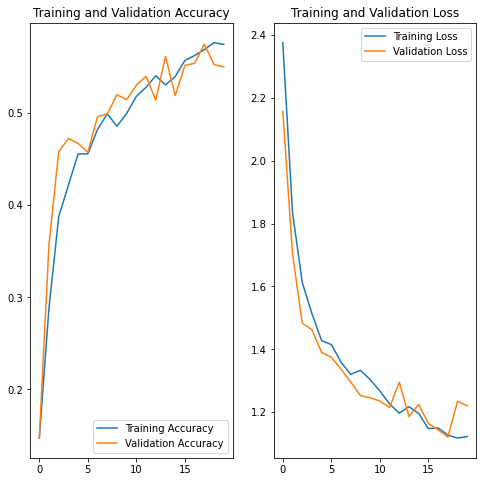

In [24]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# Findings

1. Accurancy of the training and validation are reduced which indicates overfitting has been reduced.
2. Loss for both training and validation are reducing.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [25]:
## Your code goes here.
counts = []
for i in range(len(class_names)):
    counts.append(len(os.listdir(os.path.join(root_path,"Train", class_names[i]))))

original_df = pd.DataFrame({
    "ClassName": class_names,
    "ClassCount":counts
})
original_df = original_df.sort_values(by="ClassCount", ascending=False)
print(original_df)

                    ClassName  ClassCount
5  pigmented benign keratosis         463
3                    melanoma         439
1        basal cell carcinoma         377
4                       nevus         358
7     squamous cell carcinoma         182
8             vascular lesion         140
0           actinic keratosis         115
2              dermatofibroma          96
6        seborrheic keratosis          78


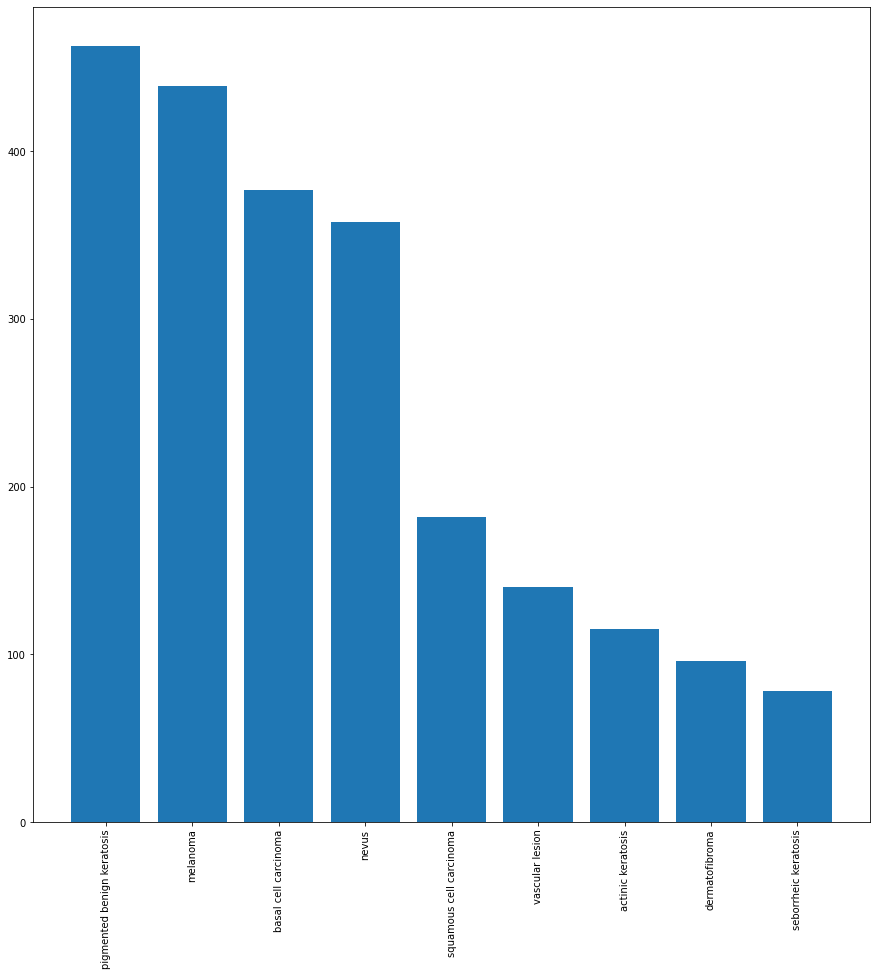

In [26]:
plt.figure(figsize=(15,15)) 
plt.bar(original_df["ClassName"], original_df["ClassCount"])
plt.xticks(rotation=90)
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
Ans - seborrheic keratosis with 77 images.

#### - Which classes dominate the data in terms proportionate number of samples?

Ans - pigmented benign keratosis with 462 images.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(os.path.join(root_path,"Train", i))
    p.rotate(probability = 0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA8B61209D0>: 100%|██████████| 500/500 [00:18<00:00, 26.92 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA8B7ECCB90>: 100%|██████████| 500/500 [00:19<00:00, 25.12 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA8CC5B0F90>: 100%|██████████| 500/500 [00:21<00:00, 22.96 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=964x640 at 0x7FA8CC58AA90>: 100%|██████████| 500/500 [01:45<00:00,  4.74 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FA924181710>: 100%|██████████| 500/500 [01:10<00:00,  7.09 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA7B3BC0790>: 100%|██████████| 500/500 [00:18<00:00, 26.42 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FA924047190>: 100%|██████████| 500/500 [00:41<00:00, 12.05 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA8B6CB8BD0>: 100%|██████████| 500/500 [00:18<00:00, 27.53 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA933A73550>: 100%|██████████| 500/500 [00:17<00:00, 28.43 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029501.jpg_08d72207-a74c-4b80-920b-9457ee72e627.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030096.jpg_148ba626-f141-4534-a5d0-4c28a5db9f88.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025940.jpg_1e3ee1e1-6630-4474-ac7f-8da4dcf3387b.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027478.jpg_9f205df7-9854-48d0-b1a0-a8b4b7eab280.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',


In [32]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [33]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [34]:
new_df['Label'].value_counts()

basal cell carcinoma          1000
actinic keratosis             1000
dermatofibroma                1000
melanoma                      1000
nevus                         1000
pigmented benign keratosis    1000
seborrheic keratosis          1000
squamous cell carcinoma       1000
vascular lesion               1000
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [35]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [36]:
data_dir_train=os.path.join(root_path, 'Train')
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    subset="training",
    validation_split = 0.2
    )

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### **Todo:** Create a validation dataset

In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [43]:
## your code goes here
# Sequential model creation
model_2 = Sequential()

# Rescaling the pixel values between (0,1)
model_2.add(layers.Rescaling(scale = 1./255, input_shape = (180,180,3)))


# First convolution layer
model_2.add(layers.Conv2D(16,3,padding='same',activation= 'relu'))
model_2.add(layers.BatchNormalization())
model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_2.add(layers.Dropout(0.25))

# Second convolution layer
model_2.add(layers.Conv2D(32,3,padding='same',activation= 'relu'))
model_2.add(layers.BatchNormalization())
model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_2.add(layers.Dropout(0.25))

# Third convolution layer
model_2.add(layers.Conv2D(64,3,padding='same',activation= 'relu'))
model_2.add(layers.BatchNormalization())
model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_2.add(layers.Dropout(0.25))

model_2.add(layers.Conv2D(128,3,padding='same',activation= 'relu'))
model_2.add(layers.BatchNormalization())
model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_2.add(layers.Dropout(0.25))

# Flattern and Dense Layer
model_2.add(layers.Flatten())
model_2.add(layers.Dense(256,activation='relu'))
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Dense(num_class_names, activation= 'softmax'))

In [44]:
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 batch_normalization_3 (Batc  (None, 180, 180, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 90, 90, 16)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)       

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [45]:
## your code goes here
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [46]:
epochs = 50
## Your code goes here, use 50 epochs.
history_2 = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
281/281 [==============================] - 48s 164ms/step - loss: 2.6220 - accuracy: 0.2038 - val_loss: 3.8583 - val_accuracy: 0.1727
Epoch 2/50
281/281 [==============================] - 47s 165ms/step - loss: 1.8313 - accuracy: 0.3096 - val_loss: 2.4642 - val_accuracy: 0.3244
Epoch 3/50
281/281 [==============================] - 47s 163ms/step - loss: 1.6844 - accuracy: 0.3492 - val_loss: 1.8085 - val_accuracy: 0.3543
Epoch 4/50
281/281 [==============================] - 48s 168ms/step - loss: 1.5620 - accuracy: 0.3763 - val_loss: 2.0841 - val_accuracy: 0.3578
Epoch 5/50
281/281 [==============================] - 46s 162ms/step - loss: 1.4891 - accuracy: 0.4129 - val_loss: 1.6471 - val_accuracy: 0.4352
Epoch 6/50
281/281 [==============================] - 47s 164ms/step - loss: 1.4098 - accuracy: 0.4394 - val_loss: 1.2194 - val_accuracy: 0.5136
Epoch 7/50
281/281 [==============================] - 47s 165ms/step - loss: 1.3626 - accuracy: 0.4573 - val_loss: 1.2438 - val_ac

#### **Todo:**  Visualize the model results

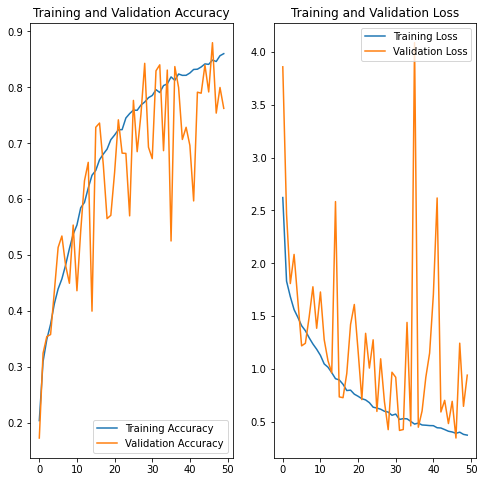

In [47]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Conclusion : 
 1. Overfitting and underfitting is resolved after applying the Augmentor pipeline.
 2. Training accurancy - 86%(0.8602) and Validation accurancy - 76%(0.7623)


